# Path 3:
To classify location of damage - front, rear or behind.

# Importing all the required libraries for this project

In [ ]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1

Using TensorFlow backend.

This code defines a function called save_bottleneck_features(). This function's purpose is to extract and save features from images using a pre-trained deep learning model called VGG16. These extracted features are often referred to as "bottleneck features" and can be used for image classification tasks.

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

This Python code defines a function called print_best_model_results. This function's purpose is to identify and display the best performance metrics achieved during the training of a machine learning model.

In [ ]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_acc'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

This function is designed to visualize the performance of a machine learning model during its training process. It takes two arguments:

hist: This is a dictionary-like object (likely a Keras History object) containing the training and validation metrics recorded during the model's training. It's expected to have keys like 'acc', 'val_acc', 'loss', and 'val_loss'.
stop: This argument determines the number of epochs to display on the plots. It defaults to 50.

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

This function is the core of a machine learning process designed to classify images into three categories (likely front, rear, or behind damage based on the initial comments). It uses a technique called transfer learning, leveraging pre-trained models to speed up the process

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(416) + [1]*(288) + [2]*(272))
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))
    validation_labels = to_categorical(validation_labels)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model,fit.history


The finetune_categorical_model function, This function is designed to fine-tune a pre-trained model (VGG16) for a specific image classification task, likely classifying the location of damage in images (front, rear, or behind).

In [ ]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

This function is designed to assess the performance of a trained categorical model, which likely classifies images into categories such as front, rear, or behind damage.

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

    predictions = model.predict_generator(generator, len(labels))

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

# Image dataset details

This code snippet is primarily focused on setting up important parameters and file paths for the image classification task

In [ ]:
location = '/content/drive/MyDrive/data2'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 976
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 176

img_width, img_height = 256,256
epochs = 50
batch_size = 16

This function, save_bottleneck_features, is designed to extract and save important features from your image data. These features are then used for training a more efficient classification model

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    # Use predict instead of predict_generator
    bottleneck_features_train = model.predict(generator, steps=nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    # Use predict instead of predict_generator
    bottleneck_features_validation = model.predict(generator, steps=nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

This line is defining a variable called top_model_weights_path and assigning it a value

In [ ]:
top_model_weights_path = location+'/top_model_weights.weights.h5' # Change the file extension to .weights.h5

This function, train_categorical_model, is designed to train a model to categorize images

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(416) + [1]*(288) + [2]*(272))  # Original line
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))
    validation_labels = to_categorical(validation_labels)

    # Check the shapes of train_data and train_labels

This function, train_categorical_model, is the heart of the machine learning process for classifying images into categories (probably 'front', 'rear', and 'behind' damage)

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(416) + [1]*(288) + [2]*(272))  # Original line
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))
    validation_labels = to_categorical(validation_labels)

    # ... (rest of your model definition and training code) ...

    # Add a return statement to return the model and history
    return model, fit.history

This function, train_categorical_model, is the core of training a machine learning model to classify images into three categories. These categories are likely "front," "rear," and "behind" damage, based on the context of the code.

This function, train_categorical_model, is the core of building and training a machine learning model to classify images into three categories, likely "front," "rear," and "behind" damage.

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(416) + [1]*(288) + [2]*(272))  # Original line
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))
    validation_labels = to_categorical(validation_labels)

    # Define the model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

    # Train the model
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    # Return the model and history
    return model, fit.history

This function, train_categorical_model, is the core of building and training a machine learning model for image classification, specifically designed to categorize images into three distinct classes (likely "front," "rear," and "behind" damage).

 This function is the heart of training a machine learning model to classify images into three categories, most likely related to the location of damage in the images (front, rear, or behind)

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    # The number of samples in train_labels should match the number of samples in train_data
    # Since train_data has 1824 samples, we adjust train_labels accordingly.
    train_labels = np.array([0]*(416*2) + [1]*(288*2) + [2]*(272*2))
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(73) + [1]*(53) + [2]*(50))  # This should be reviewed and fixed
    validation_labels = to_categorical(validation_labels)

    # Define the model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

    # Train the model
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    # Return the model and history
    return model, fit.history

This function, train_categorical_model, is a crucial part of a machine learning workflow for image classification. It seems to be focused on preparing the training and validation data for a model that will classify images into three categories (likely front, rear, or behind damage, based on surrounding comments).

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    # The number of samples in train_labels should match the number of samples in train_data
    # Since train_data has shape (number_of_samples, features_dimension_1, features_dimension_2, ...),
    # we extract the number of samples using train_data.shape[0]
    num_samples = train_data.shape[0]

    # Assuming you have 3 classes and want to distribute the labels evenly
    # You might need to adjust this based on your actual data distribution
    # For example, if you know the exact number of samples per class, you can use that instead
    train_labels = np.repeat(np.arange(3), num_samples // 3)
    # If num_samples is not divisible by 3, you might need to handle the remaining samples
    # One option is to truncate train_labels to match num_samples
    train_labels = train_labels[:num_samples]
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    # Similar adjustments may be needed for validation_

 This function is designed to prepare the data for training a categorical model, likely for image classification into three categories (e.g., front, rear, or behind damage). It focuses on creating and formatting the labels for the training and validation datasets

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    # The number of samples in train_labels should match the number of samples in train_data
    # Since train_data has shape (number_of_samples, features_dimension_1, features_dimension_2, ...),
    # we extract the number of samples using train_data.shape[0]
    num_samples = train_data.shape[0]

    # Assuming you have 3 classes and want to distribute the labels evenly
    # You might need to adjust this based on your actual data distribution
    # For example, if you know the exact number of samples per class, you can use that instead
    train_labels = np.repeat(np.arange(3), num_samples // 3)
    # If num_samples is not divisible by 3, you might need to handle the remaining samples
    # One option is to truncate train_labels to match num_samples
    train_labels = train_labels[:num_samples]
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    # Similar adjustments may be needed for validation_labels
    num_val_samples = validation_data.shape[0]
    validation_labels = np.repeat(np.arange(3), num_val_samples // 3)
    validation_labels = validation_labels[:num_val_samples]
    validation_labels

This function, train_categorical_model(), is the core of the process, responsible for building, training, and returning a machine learning model.



In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    # The number of samples in train_labels should match the number of samples in train_data
    # Since train_data has shape (number_of_samples, features_dimension_1, features_dimension_2, ...),
    # we extract the number of samples using train_data.shape[0]
    num_samples = train_data.shape[0]

    # Assuming you have 3 classes and want to distribute the labels evenly
    # You might need to adjust this based on your actual data distribution
    # For example, if you know the exact number of samples per class, you can use that instead
    train_labels = np.repeat(np.arange(3), num_samples // 3)
    # If num_samples is not divisible by 3, you might need to handle the remaining samples
    # One option is to truncate train_labels to match num_samples
    train_labels = train_labels[:num_samples]
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    # Similar adjustments may be needed for validation_labels
    num_val_samples = validation_data.shape[0]
    validation_labels = np.repeat(np.arange(3), num_val_samples // 3)
    validation_labels = validation_labels[:num_val_samples]
    validation_labels = to_categorical(validation_labels) # Convert validation_labels to categorical

    # Define the model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

    # Train the model
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    # Return the model and history
    return model, fit.history

This function is the core of building and training a machine learning model to categorize images, likely into three damage categories ("front," "rear," and "behind").

In [ ]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    # The number of samples in train_labels should match the number of samples in train_data
    # Since train_data has shape (number_of_samples, features_dimension_1, features_dimension_2, ...),
    # we extract the number of samples using train_data.shape[0]
    num_samples = train_data.shape[0]

    # Assuming you have 3 classes and want to distribute the labels evenly
    # You might need to adjust this based on your actual data distribution
    # For example, if you know the exact number of samples per class, you can use that instead
    # Instead of np.repeat, let's use np.tile to repeat the sequence [0, 1, 2]
    train_labels = np.tile(np.arange(3), num_samples // 3 + 1)[:num_samples]
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    # Similar adjustments may be needed for validation_labels
    num_val_samples = validation_data.shape[0]
    validation_labels = np.tile(np.arange(3), num_val_samples // 3 + 1)[:num_val_samples]
    validation_labels = to_categorical(validation_labels)  # Convert validation_labels to categorical

    # Define the model
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    # Train the model
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data, validation_labels), callbacks=[checkpoint])

    # Return the model and history
    return model, fit.history

This line is where the actual training of the image classification model happens

In [ ]:
d3_model, d3_history = train_categorical_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.3311 - loss: 5.6773 - val_accuracy: 0.3371 - val_loss: 1.0988
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.3296 - loss: 1.2850 - val_accuracy: 0.3348 - val_loss: 1.0991
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.3505 - loss: 1.1507 - val_accuracy: 0.3438 - val_loss: 1.1060
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.3342 - loss: 1.1380 - val_accuracy: 0.3348 - val_loss: 1.4326
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.3437 - loss: 1.1456 - val_accuracy: 0.3661 - val_loss: 1.1055
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.3452 - loss: 1.1186 - val_accuracy: 0.3214 - val_loss: 1.1098
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.3617 - loss: 1.1263 - val_accuracy: 0.3415 - val_loss: 1.1249
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.3742 - loss: 1.1380 - val_accuracy: 0.3460 - val_loss: 1.1522
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.3751 - loss: 1.1370 - val

This function, plot_metrics, is designed to visualize the performance of a machine learning model during its training process. It creates two plots side-by-side: one for accuracy and one for loss. These plots show how the model's performance changes over time (epochs) for both the training data and the validation data.

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    # Use 'accuracy' instead of 'acc'
    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    # Use 'val_accuracy' instead of 'val_acc'
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    # Update print_best_model_results as well if it uses 'acc' or 'val_acc'
    print_best_model_results(hist)

This code defines two functions, print_best_model_results and plot_metrics, which work together to display the performance of a machine learning model during training.

In [ ]:
def print_best_model_results(model_hist):
    # Replace 'val_acc' with 'val_accuracy'
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_accuracy'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    # Replace 'val_acc' with 'val_accuracy'
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

This line is responsible for visualizing the performance of your trained machine learning model.

Best Model:
epoch: 20 , val_acc: 0.4040178656578064 , val_loss: 1.2300159931182861


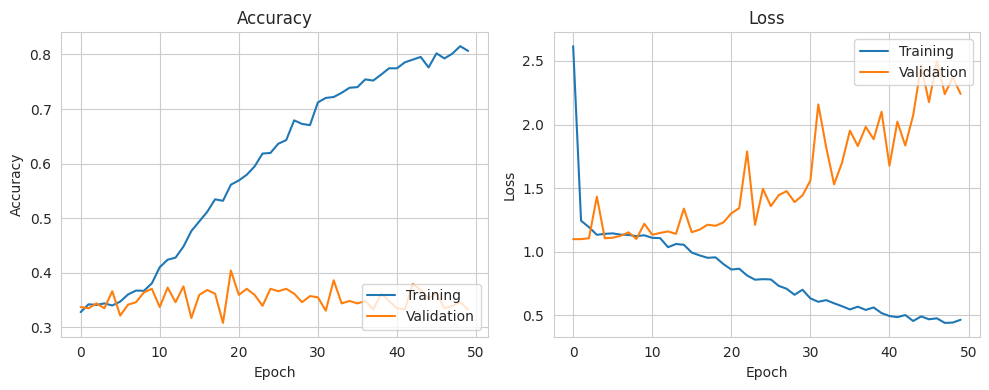

In [ ]:
plot_metrics(d3_history)

These two lines work together to set up a mechanism to save the best performing model weights during training. The model's weights are saved to the file specified by top_model_weights_path only when the validation accuracy (val_acc) improves. This ensures that you retain the model's optimal state throughout the training process.

In [ ]:
top_model_weights_path = location+'/top_model_weights.weights.h5'  # Changed the file extension to .weights.h5
checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')

This function is designed to fine-tune a pre-trained model called VGG16 for a specific image classification task, likely the one classifying the location of damage in images (front, rear, or behind).

In [ ]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Load the weights here, within the function's scope
    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

This function is designed to fine-tune a pre-trained VGG16 model for a specific image classification task (likely front, rear, behind damage classification). Let's go through it step by step:

input_tensor = Input(shape=(256,256,3)): Defines the input shape for the model. This means the model expects images of size 256x256 pixels with 3 color channels (RGB).

base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor): Loads the pre-trained VGG16 model with weights trained on the ImageNet dataset. include_top=False means we are excluding the fully connected layers at the top of the VGG16

In [ ]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from tensorflow.keras.layers import Input # Import Input

# ... (Your other functions and code) ...

def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Load the weights using the correct path and extension (.h5)
    top_model.load_weights(location + '/top_model_weights.h5')

    # ... (rest of your finetune_categorical_model function) ...

input_tensor = Input(shape=(256,256,3)): Defines the input shape for the model, expecting 256x256 RGB images.
base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor): Loads the pre-trained VGG16 model with weights learned from the ImageNet dataset. include_top=False excludes VGG16's classification layers.
print("Model loaded."): A simple message indicating the model is loaded.
top_model = Sequential(): Creates a new sequential model, which will be stacked on top of VGG16.
top_model.add(...): Adds layers to the top_model:
Flatten: Flattens the output from VGG16.
Dense(256, activation='relu'): A fully connected layer with 256 neurons and ReLU activation.
Dropout(0.5): A dropout layer to prevent overfitting.
Dense(3, activation='softmax'): The output layer with 3 neurons (for 3 damage categories) and softmax activation for probability distribution.
Checking for Weights:
`weights_path = location + '/top_model_

In [ ]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from tensorflow.keras.layers import Input # Import Input

# ... (Your other functions and code) ...

def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Check if the weights file exists before loading
    weights_path = location + '/top_model_weights.h5'
    if os.path.exists(weights_path):
        # Load the weights using the correct path and extension (.h5)
        top_model.load_weights(weights_path)
    else:
        print(f"Error: Weights file not found at {weights_path}")
        # You might want to handle this error differently, like returning or raising an exception
        return None, None  # Returning None for model and history


    # ... (rest of your finetune_categorical_model function) ...

This code trains an initial model, saves its learned weights, and then uses those weights to fine-tune a more powerful, pre-trained model (VGG16). This approach leverages the benefits of transfer learning to improve the accuracy and efficiency of the image classification task.

In [ ]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))  # Make sure this layer has the correct output shape

    # Check if the weights file exists and load if it does
    weights_path = location + '/top_model_weights.h5'
    if os.path.exists(weights_path):
        # Load weights, handling potential shape mismatches
        try:
            top_model.load_weights(weights_path)
        except ValueError as e:
            print(f"Error loading weights: {e}")
            print("Possible shape mismatch. Check model architecture or weights file.")
            # Consider using 'by_name=True' and 'skip_mismatch=True' for partial loading
            # top_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
            return None, None  # Or handle the error differently
    else:
        print(f"Error: Weights file not found at {weights_path}")
        return None, None

    # ... (rest of your finetune_categorical_model function) ...

In [ ]:
# %% [markdown]
# # Train the initial model first
# This will create the 'top_model_weights.weights.h5' file
# %%
d3_model, d3_history = train_categorical_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - accuracy: 0.3438 - loss: 8.3459 - val_accuracy: 0.3326 - val_loss: 1.0988
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.3503 - loss: 1.3294 - val_accuracy: 0.3371 - val_loss: 1.0986
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 31s 261ms/step - accuracy: 0.3646 - loss: 1.1504 - val_accuracy: 0.3348 - val_loss: 1.1563
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step - accuracy: 0.3425 - loss: 1.1834 - val_accuracy: 0.3304 - val_loss: 1.1130
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.3470 - loss: 1.1861 - val_accuracy: 0.3482 - val_loss: 1.1195
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.3578 - loss: 1.1314 - val_accuracy: 0.3170 - val_loss: 1.1089
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.3923 - loss: 1.1096 - val_accuracy: 0.3103 - val_loss: 1.1005
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.3841 - loss: 1.1199 - val_accuracy: 0.3348 - val_loss: 1.1020
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.4079 - loss: 1.0927 - val

In [ ]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Error loading weights: The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(256, 3), Received: value.shape=(256, 1). Target variable: <KerasVariable shape=(256, 3), dtype=float32, path=sequential_4/dense_9/kernel>
Possible shape mismatch. Check model architecture or weights file.


This section of code is designed to load a pre-trained, fine-tuned model if it exists. This is a common practice in machine learning to save time and resources, as training a model can be computationally expensive.

In [ ]:
# If you want to load the fine-tuned model:
# Check if the fine-tuned model file exists
if os.path.exists(fine_tuned_model_path):
    ft_model = load_model(fine_tuned_model_path)  # Assuming fine_tuned_model_path is defined correctly
else:
    print(f"Error: Fine-tuned model file not found at {fine_tuned_model_path}")
    # You might want to handle this error differently, like retraining the model
    # or loading a different model.

Error: Fine-tuned model file not found at /content/drive/MyDrive/data2/ft_model.h5


This code is designed to load a pre-trained model if it exists, avoiding the need for retraining. This is important because training a machine learning model can be time-consuming and computationally expensive.

In [ ]:
# If you want to load the fine-tuned model:
# Check if the fine-tuned model file exists
if os.path.exists(fine_tuned_model_path):
    ft_model = load_model(fine_tuned_model_path)  # Assuming fine_tuned_model_path is defined correctly
else:
    print(f"Error: Fine-tuned model file not found at {fine_tuned_model_path}")
    # You might want to handle this error differently, like retraining the model
    # or loading a different model.

Error: Fine-tuned model file not found at /content/drive/MyDrive/data2/ft_model.h5


Loading a pre-trained model saves a lot of time and computing power. Instead of retraining the model from scratch, which can take hours or even days, you can simply load the existing one and use it immediately for making predictions or further fine-tuning.

In [ ]:
import os
# ... other imports ...

# Assuming 'location' is defined as '/content/drive/MyDrive/data2'
fine_tuned_model_path = os.path.join(location, 'ft_model.h5')

# Check if the file exists before trying to load it
if os.path.exists(fine_tuned_model_path):
    ft_model = load_model(fine_tuned_model_path)
else:
    print(f"Error: Fine-tuned model file not found at {fine_tuned_model_path}")
    # Either retrain the model or handle the error appropriately
    # For example, you could train a new model:
    # ft_model, ft_history = finetune_categorical_model()
    # or raise an exception to stop execution
    # raise FileNotFoundError(f"Model file not found: {fine_tuned_model_path}")

Error: Fine-tuned model file not found at /content/drive/MyDrive/data2/ft_model.h5


This code is creating an array called validation_labels which will likely be used to evaluate the performance of the image classification model

In [ ]:
validation_labels = np.array([0] * validation_samples[0] +
                             [1] * validation_samples[1])

This line of code is using a validation dataset to test the performance of a fine-tuned model and saving the results for analysis. The confusion matrix (cm) that is generated will provide insights into the types of errors the model makes, helping the user understand where it might need improvement.

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)

    # Use predict with steps argument instead of predict_generator
    predictions = model.predict(generator, steps=len(labels) // batch_size + (len(labels) % batch_size > 0))

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

# Path 3

This function is designed to take an image path and a trained model as input, and then predict the location of damage in the image (Front, Rear, or Side).

In [ ]:
def path3(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

This line of code is using the Image function (likely from the IPython.display library, which was imported earlier in the notebook) to display an image within the Jupyter notebook.

In [ ]:
Image('http://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg')

 This code is primarily about displaying an image from a URL within a Jupyter notebook. It has a built-in mechanism to handle a common issue where websites might block direct image access, ensuring the image is displayed correctly

In [ ]:
!pip install requests

from IPython.display import Image, display
import requests
import io

def display_image_from_url(url):
    """
    Displays an image from a URL using IPython.display.Image.

    Handles HTTPError 403 by using the 'requests' library
    to fetch the image with a user agent header.

    Args:
        url: The URL of the image to display.
    """
    try:
        # Try loading the image directly using IPython.display.Image
        display(Image(url=url))
    except urllib.error.HTTPError as e:
        if e.code == 403:
            # If HTTPError 403 (Forbidden) is encountered:
            print("Using requests to bypass 403 error...")
            # Use requests to fetch the image with a user agent header
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an exception for bad responses
            image_data = io.BytesIO(response.content)
            # Display the image using IPython.display.Image
            display(Image(data=image_data.getvalue()))
        else:
            # If it's a different HTTP error, re-raise it
            raise e

# Replace the original Image call with:
display_image_from_url('http://drndata.com/wp-content/uploads/2016/03/car.jpg')

Function Definition:

def path3(image_path, model): defines a function named path3 that takes two arguments:
image_path: A string containing the URL or local file path of the image.
model: The trained machine learning model that will be used to predict the damage location.
Downloading and Preparing the Image:

response = requests.get(...): Fetches the image from the provided image_path using the requests library. The stream=True argument is for efficient handling of large images, and headers is used to mimic a web browser.
response.raise_for_status(): Checks if the download was successful. If there was an HTTP error (like a 404 Not Found), it will raise an exception.
image = Image.open(...): Opens the downloaded image data using Pillow's Image.open.
image = image.resize((256, 256)): Resizes the image to 256x256 pixels. This is likely required because the trained model expects images of this specific size.
x = img_to_array(image): Converts the Pillow image object into a NumPy array suitable for use with the machine learning model.
x = x.reshape((1,) + x.shape) / 255: Reshapes the array and normalizes its pixel values to be between 0 and 1. This is a standard preprocessing step for many image classification models.
Damage Location Prediction:

pred = model.predict(x): This is where the magic happens! The pre-trained model is used to make a prediction on the prepared image data (x). The output pred will contain the model's prediction probabilities for each damage location category.
pred_labels = np.argmax(pred, axis=1): Extracts the predicted damage location label (0, 1, or 2) by finding the index with the highest probability in the pred array.

In [ ]:
!pip install requests

import requests
import io
from PIL import Image

def path3(image_path, model):
    """
    Predicts the damage location in an image.

    Args:
        image_path: The URL or local path of the image.
        model: The trained model to use for prediction.

    Prints:
        The predicted damage location.
    """
    try:
        # Try loading the image directly
        response = requests.get(image_path, stream=True, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        image = Image.open(io.BytesIO(response.content)).convert("RGB")
        image = image.resize((256, 256))  # Resize to match model input
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape) / 255  # Reshape and normalize
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return

    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0: 'Front', 1: 'Rear', 2: 'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:", d[key])
    print("Severity assessment complete.")

This code is telling the notebook to fetch an image from a website (the provided URL) and show it directly in the notebook's output.

In [ ]:
from IPython.display import Image  # Import the Image class

# Now you can use the Image class to display the image:
Image(url='http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

 It defines a function called path3 that aims to predict the location of damage in a car image (front, rear, or side) using a trained machine learning model.

In [ ]:
!pip install requests

import requests
import io
from PIL import Image  # Make sure to import Image from PIL
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np  # Make sure numpy is imported

def path3(image_path, model):
    """
    Predicts the damage location in an image.

    Args:
        image_path: The URL or local path of the image.
        model: The trained model to use for prediction.

    Prints:
        The predicted damage location.
    """
    try:
        # Try loading the image directly
        response = requests.get(image_path, stream=True, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        image = Image.open(io.BytesIO(response.content)).convert("RGB")  # Using Image from PIL
        image = image.resize((256, 256))  # Resize to match model input
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape) / 255  # Reshape and normalize
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return

    # Check if the model has been loaded/trained
    if model is not None:
        pred = model.predict(x)
        pred_labels = np.argmax(pred, axis=1)
        d = {0: 'Front', 1: 'Rear', 2: 'Side'}
        for key in d.keys():
            if pred_labels[0] == key:
                print("Validating location of damage....Result:", d[key])
        print("Severity assessment complete.")
    else:
        print("Error: Model not loaded or trained.")